# Model Image Classification

## Download Package

In [1]:
!gdown https://drive.google.com/drive/folders/sdsldkfj...somefileid.. -O /some_parent_directory/some_child_directory

/usr/local/lib/python3.7/dist-packages/gdown/parse_url.py:39: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  url="https://drive.google.com/uc?id={}".format(file_id)
Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/gdown/cli.py", line 166, in main
    resume=args.continue_,
  File "/usr/local/lib/python3.7/dist-packages/gdown/download.py", line 202, in download
    for file in os.listdir(osp.dirname(output) or "."):
FileNotFoundError: [Errno 2] No such file or directory: '/some_parent_directory'


## Importing Library

In [2]:
import os
import gdown
import zipfile
import pathlib

import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from google.colab import files

%matplotlib inline
plt.style.use('seaborn')
print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.8.2


## Data Preparation

In [3]:
url = 'https://drive.google.com/uc?id=1Sm4gAurI9er46i3MqQ5K9_0tPIIbmHSH'
output = 'datasets.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Sm4gAurI9er46i3MqQ5K9_0tPIIbmHSH
To: /content/datasets.zip
100%|██████████| 84.2M/84.2M [00:00<00:00, 136MB/s]


'datasets.zip'

In [4]:
local_zip = os.path.join('./', output)
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

Total image from this datasets : 7692


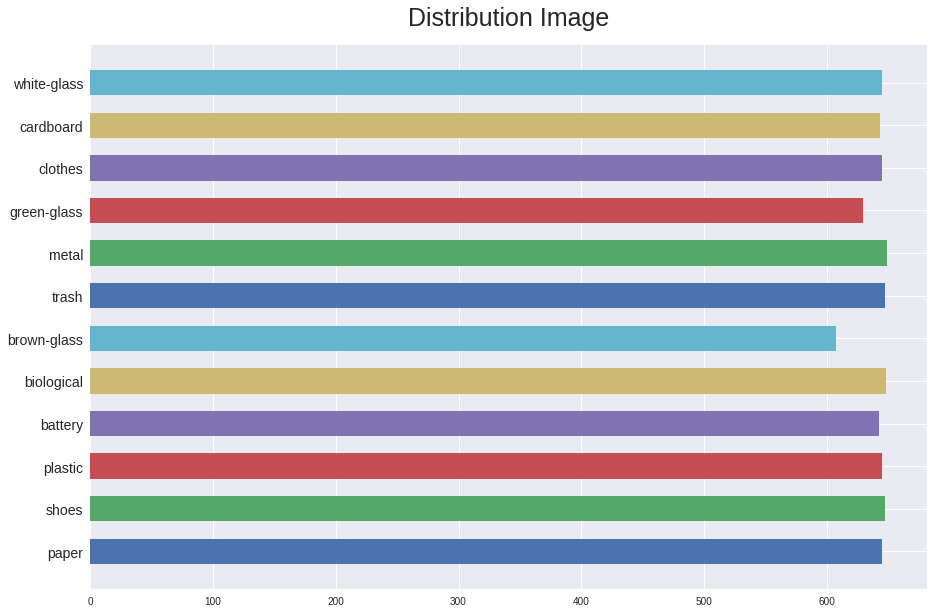

In [5]:
PATH = './garbage_classification'
data_dir = pathlib.Path(PATH)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'Total image from this datasets : {image_count}')

plt.figure(figsize=(15,10))
plt.rc('ytick', labelsize=14) 
for i, label in enumerate(os.listdir(data_dir)):
  label_dir = os.path.join(data_dir, label)
  len_label_dir = len(os.listdir(label_dir))
  plt.barh(label, len_label_dir, label=label, height=0.6)
  plt.title('Distribution Image', fontsize=25, pad=20)

## Data preprocessing

### Set up Paramters

In [6]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

np.random.seed(123)
seed = np.random.randint(0,100)
print(f"Current seed : {seed}")

Current seed : 66


### Load data using a Keras utility

In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

val_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 7692 files belonging to 12 classes.
Using 6154 files for training.
Found 7692 files belonging to 12 classes.
Using 1538 files for validation.


In [8]:
class_names = np.array(train_dataset.class_names)
class_names_val = np.array(val_dataset.class_names)

print(f'List label Train data: \n{class_names}\n')
print(f'List label Validation data: \n{class_names_val}')

List label Train data: 
['battery' 'biological' 'brown-glass' 'cardboard' 'clothes' 'green-glass'
 'metal' 'paper' 'plastic' 'shoes' 'trash' 'white-glass']

List label Validation data: 
['battery' 'biological' 'brown-glass' 'cardboard' 'clothes' 'green-glass'
 'metal' 'paper' 'plastic' 'shoes' 'trash' 'white-glass']


### Check Image batch

In [9]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


### Plot Data

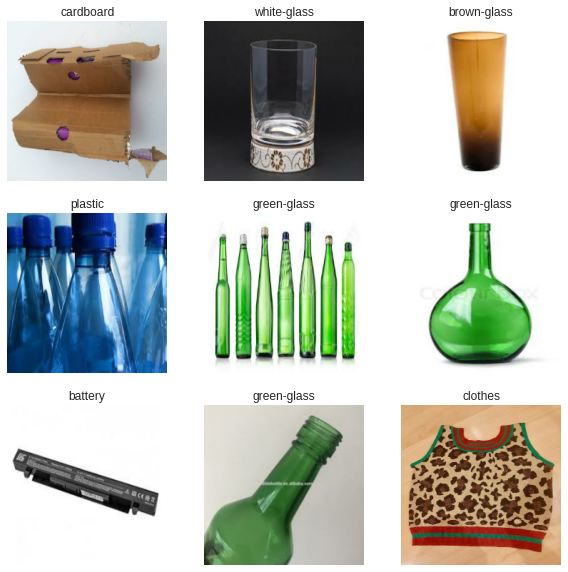

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Split Validation data to Test data

In [11]:
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches // 5)
val_dataset = val_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 40
Number of test batches: 9


### Configure data performance for Training

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(image_count//4).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Create Layer Model

#### Data Augmentation Layer

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.1)],
  name="data_augmentation")

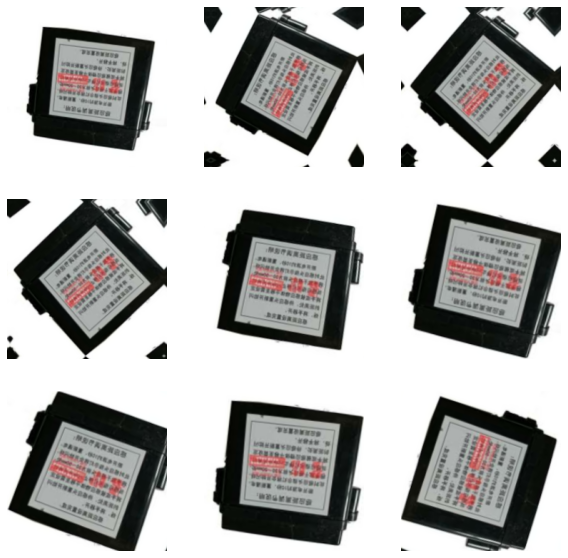

In [14]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

#### Rescale pixel Layer

In [15]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

#### Global Average Layer

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

#### Base Model Layer

In [17]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [18]:
base_model.trainable = False

#### Input Layer

In [19]:
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))

## Train Model

### Create Model

In [20]:
def model_builder():

  # Number Classes from data
  num_classes = len(class_names)

  # Create Model Sequential keras
  model = tf.keras.Sequential()

  # Add Custom Layer
  model.add(inputs)
  model.add(data_augmentation)
  model.add(normalization_layer)
  model.add(base_model)
  model.add(global_average_layer)

  # model.add(tf.keras.layers.Flatten())
  # Add fully connected layer with dropout
  model.add(tf.keras.layers.Dense(units=512, activation="relu"))
  model.add(tf.keras.layers.Dropout(0.4))

  # Prediction Layer
  model.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="final_output"))

  base_learning_rate = 1e-3
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

  return model

#### Define Callbacks

In [21]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoint_model.h5", 
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                  patience=10, 
                                                  mode ="max", 
                                                  verbose=2, 
                                                  restore_best_weights=True)

#### Build Model

In [22]:
model = model_builder()
print(f"Model : {model}")

Model : <keras.engine.sequential.Sequential object at 0x7fa97f355550>


#### Train Model

In [24]:
epoch = 100
history = model.fit(train_dataset,
                    epochs=epoch,
                    validation_data=val_dataset,
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
192/193 [============================>.] - ETA: 0s - loss: 0.3996 - accuracy: 0.8665
Epoch 1: val_accuracy improved from 0.87920 to 0.88880, saving model to checkpoint_model.h5
193/193 [==============================] - 13s 66ms/step - loss: 0.4001 - accuracy: 0.8666 - val_loss: 0.3088 - val_accuracy: 0.8888
Epoch 2/100
193/193 [==============================] - ETA: 0s - loss: 0.3929 - accuracy: 0.8645
Epoch 2: val_accuracy did not improve from 0.88880
193/193 [==============================] - 10s 54ms/step - loss: 0.3929 - accuracy: 0.8645 - val_loss: 0.3104 - val_accuracy: 0.8816
Epoch 3/100
193/193 [==============================] - ETA: 0s - loss: 0.3532 - accuracy: 0.8783
Epoch 3: val_accuracy improved from 0.88880 to 0.89600, saving model to checkpoint_model.h5
193/193 [==============================] - 11s 57ms/step - loss: 0.3532 - accuracy: 0.8783 - val_loss: 0.2892 - val_accuracy: 0.8960
Epoch 4/100
192/193 [============================>.] - ETA: 0s - loss: 0.32

### Plot Result

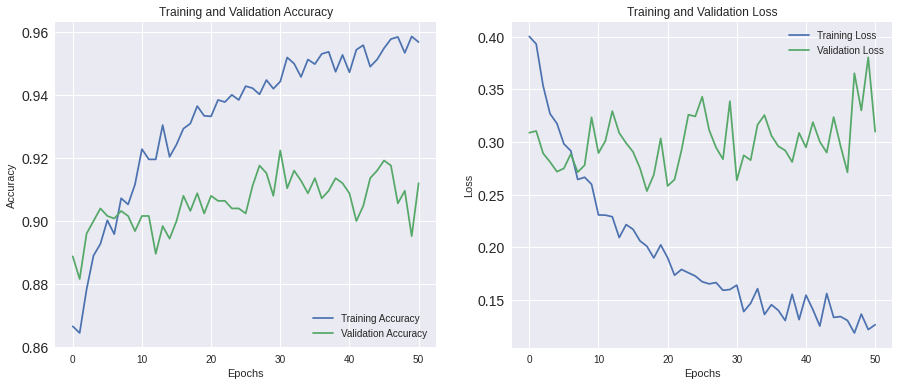

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Test Model

In [26]:
load_model = tf.keras.models.load_model('checkpoint_model.h5')

In [27]:
load_model.evaluate(x=test_dataset, return_dict=True)

9/9 [==============================] - 2s 57ms/step - loss: 0.2592 - accuracy: 0.9201


{'accuracy': 0.9201388955116272, 'loss': 0.2592391073703766}

In [28]:
image_batch_test, label_batch_test = next(iter(test_dataset))

image_batch_test, label_batch_test = image_batch_test.numpy(), label_batch_test.numpy()


predicted_batch = load_model.predict(image_batch_test)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['green-glass' 'shoes' 'white-glass' 'plastic' 'battery' 'white-glass'
 'trash' 'green-glass' 'paper' 'paper' 'trash' 'clothes' 'green-glass'
 'brown-glass' 'paper' 'metal' 'battery' 'shoes' 'trash' 'metal' 'clothes'
 'metal' 'battery' 'paper' 'white-glass' 'clothes' 'white-glass'
 'cardboard' 'trash' 'white-glass' 'shoes' 'plastic']


In [32]:
print(f"Labels:\n{label_batch_test}")
print(f"Predicted labels:\n{predicted_ids}")

true_predict = 0
false_predict = 0

for i in predicted_ids:
  if i in label_batch_test:
    true_predict +=1
  else:
    false_predict +=1

print()
print(f'True Predict Count : {true_predict}')
print(f'False Predict Count : {false_predict}')

Labels:
[ 5  9 11  8  0 11 10  5  7  7 10  4  5  2  7  6  0  9 10  6  4  6  0  7
 11  4 11  3 10 11  9  8]
Predicted labels:
[ 5  9 11  8  0 11 10  5  7  7 10  4  5  2  7  6  0  9 10  6  4  6  0  7
 11  4 11  3 10 11  9  8]

True Predict Count : 32
False Predict Count : 0


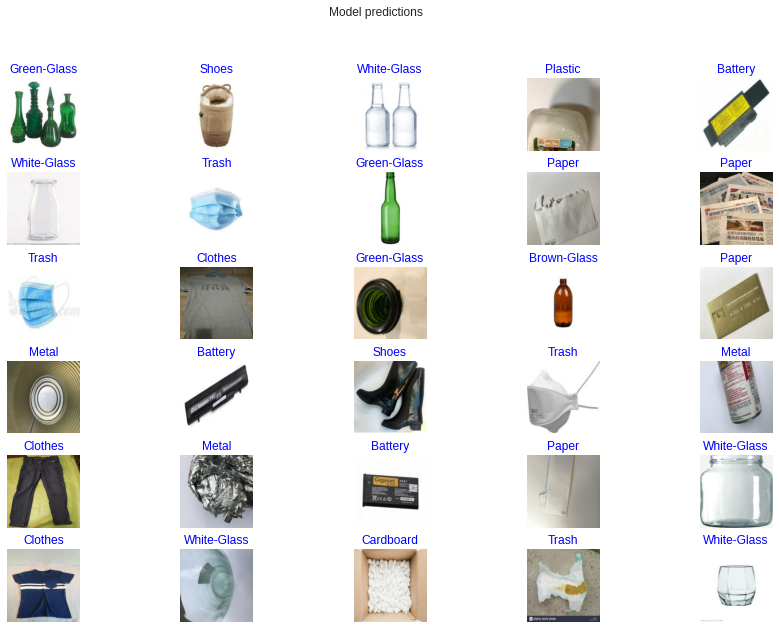

In [30]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch_test[n].astype('uint8'))
  color = "blue" if predicted_ids[n] == label_batch_test[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions")

### Model Summary

In [33]:
load_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                        

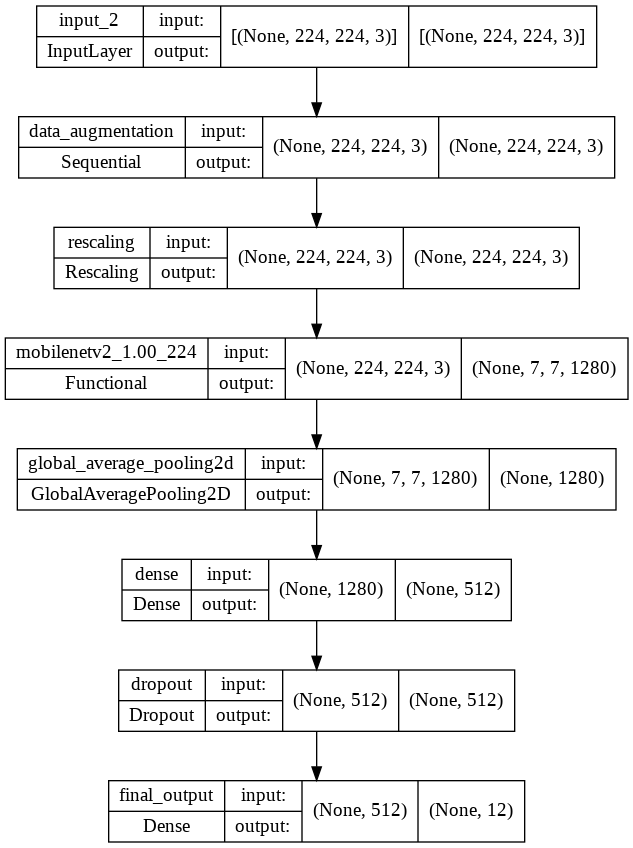

In [34]:
tf.keras.utils.plot_model(load_model,show_shapes=True)

### Download Result

In [35]:
model_path = './checkpoint_model.h5'
model_path = pathlib.Path(model_path)
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>